In [5]:
import warnings
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from prophet import Prophet

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.simplefilter("ignore", FutureWarning)

In [105]:
df = pandas.read_csv("NHL_API_point_totals_by_team_season_raw_1996-2003.csv")
team_df = df[df["team"] == "TOR"][["season_end", "total_points"]].copy()

<Axes: xlabel='season_end', ylabel='total_points'>

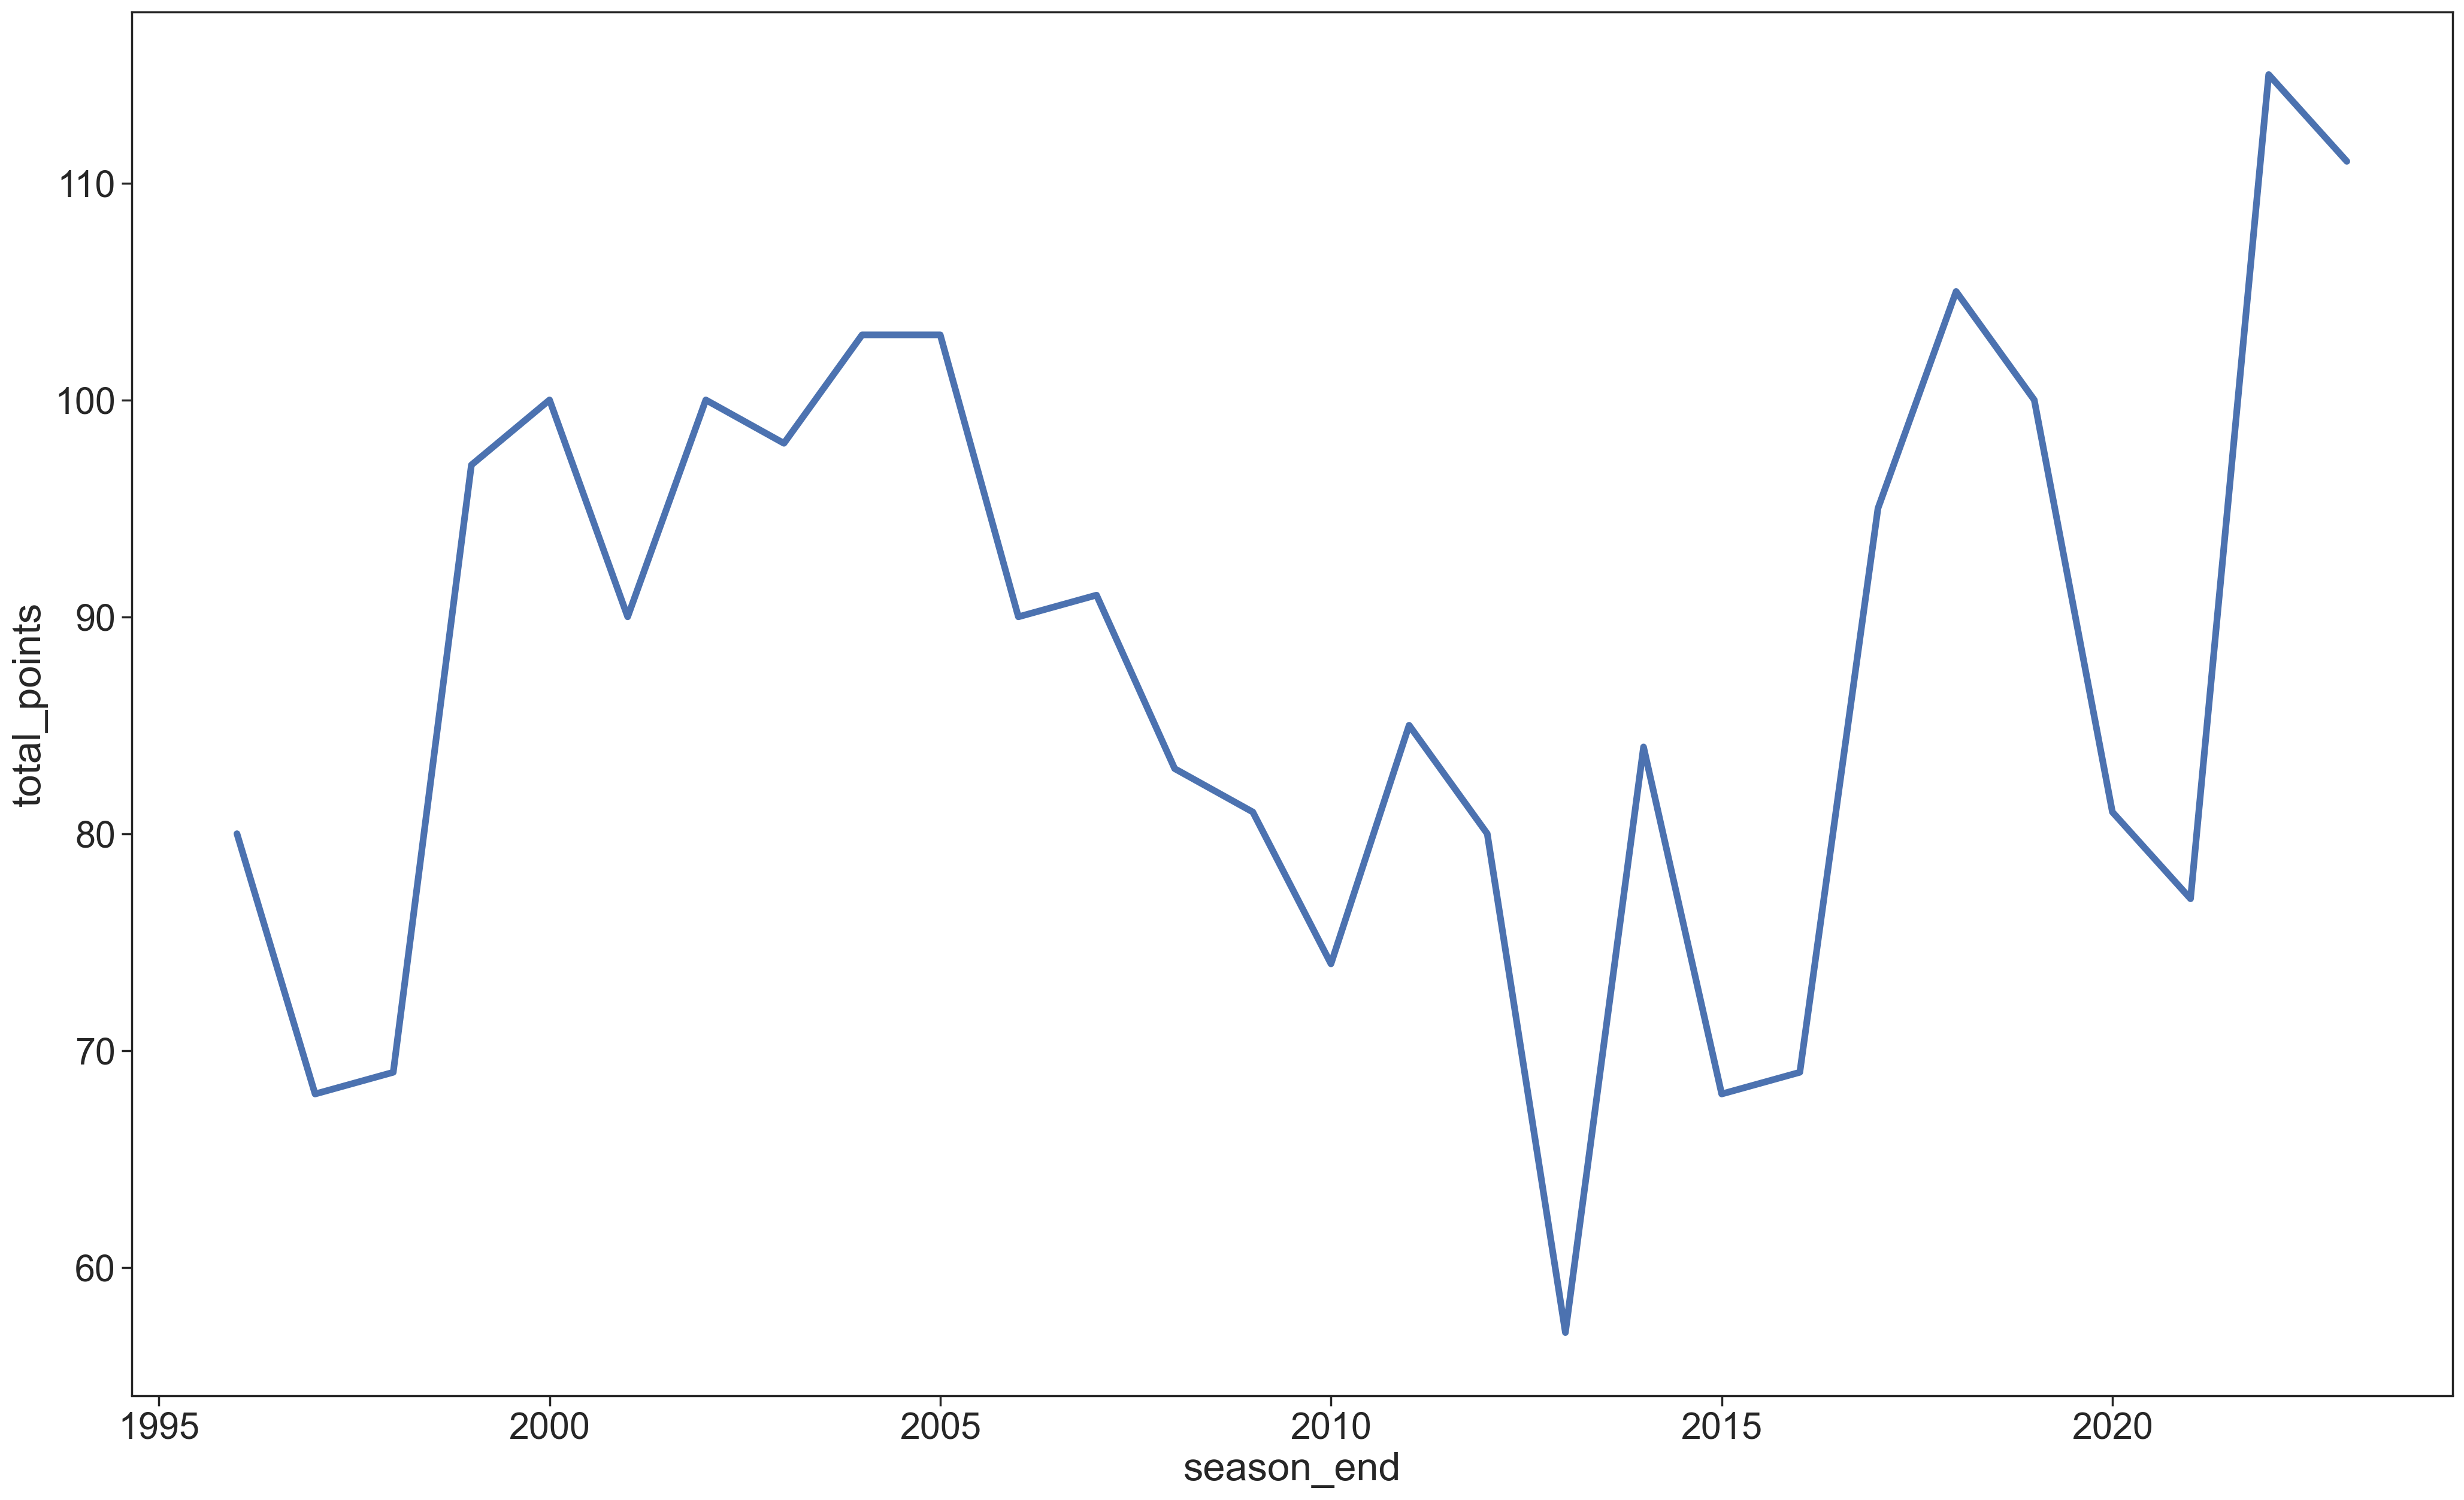

In [106]:
sns.lineplot(data=team_df, x="season_end", y="total_points", linewidth=4)

In [107]:
team_df["ds"] = team_df["season_end"].apply(lambda x : date(month=5, day=1, year=x))
team_df = team_df.rename(columns={"total_points" : "y"})
del team_df["season_end"]

In [108]:
team_df["lag1"] = team_df["y"].shift().fillna(team_df["y"].mean())
team_df["lag2"] = team_df["lag1"].shift().fillna(team_df["lag1"].mean())
team_df["lag3"] = team_df["lag2"].shift().fillna(team_df["lag2"].mean())

In [109]:
train_df = team_df[0:-1].copy()
test_df = team_df[-1:].copy()

In [110]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, mcmc_samples=1000,
            interval_width=0.95, seasonality_prior_scale=30)

In [111]:
m.add_regressor("lag1")
m.add_regressor("lag2")
m.add_regressor("lag3")

In [112]:
m.fit(train_df)

10:51:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:47 - cmdstanpy - INFO - CmdStan done processing.
10:51:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 1

In [113]:
m.predict(test_df)[["ds", "yhat_lower", "yhat", "yhat_upper"]]

,ds,yhat_lower,yhat,yhat_upper
0,2023-05-01,72.999928,111.979255,152.400405


In [114]:
test_df

,y,ds,lag1,lag2,lag3
808,111,2023-05-01,115.0,77.0,81.0


In [119]:
forecast_df = pandas.DataFrame([
    {"ds" : date(month=5, day=1, year=2024), "lag1" : test_df.iloc[-1]["y"], "lag2" : test_df.iloc[-1]["lag1"],
     "lag3" : test_df.iloc[-1]["lag2"]}])

In [120]:
m.predict(forecast_df)[["ds", "yhat_lower", "yhat", "yhat_upper"]]

,ds,yhat_lower,yhat,yhat_upper
0,2024-05-01,58.987383,95.549194,133.105292
